In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict

In [4]:
from ranking_funcs import read_imdb_actor_data,Comp_Greedy_Algo_backdoor,get_prob_backdoor_opt,rec_row_prob_back,backdoor_adjustment_opt,find_backdoor_sets_opt,Greedy_Algo,get_most_probable_elements,get_cgm,get_prob_backdoor_opt,get_probs,get_prob_backdoor,filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

# Get the current working directory
current_working_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_working_directory)


Current Working Directory: /Users/wangning/Desktop/cornell_repos/Hyper-Code/ranking_query/ranking_data_sets


In [3]:
desired_path = '/Users/wangning/Desktop/cornell_repos/Hyper-Code/ranking_query'  
os.chdir(desired_path)

In [5]:
def read_imdb_movie_actor_data(path):
    df = pd.read_csv(path)
    df['averageRating'] = round(df['averageRating'], 0)

    def runtime_category(runtime):
        if runtime <= 120: return 0
        elif runtime <= 150: return 1
        else: return 2
    df['runtimeMinutes'] = df['runtimeMinutes'].apply(runtime_category)

    def votes_category(votes):
        if votes <= 10000: return 0
        elif votes <= 50000: return 1
        elif votes <= 100000: return 2
        else: return 3
    df['numVotes'] = df['numVotes'].astype(int).apply(votes_category)
    
    def startYear_category(year):
        if year <= 2000: return 0
        elif year <= 2010: return 1
        elif year <= 2020: return 2
        else: return 3
    df['startYear'] = df['startYear'].astype(int).apply(startYear_category)

    name_map = {'Scarlett Johansson': 0,
            'Emma Mackey': 1,
            'Margot Robbie': 2,
            'Johnny Depp': 3,
            'Jason Momoa': 4,
            'Rinko Kikuchi': 5,
            'Ben Kingsley': 6,
            'Om Puri': 7}
    
    df['primaryName'] = df['primaryName'].apply(lambda x: name_map.get(x, -1))

    return df

In [6]:
df=read_imdb_movie_actor_data('ranking_data_sets/imdb_movie_stars.csv')
df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,...,Documentary,Sport,Musical,Animation,Western,Mystery,History,Action,Adventure,War
0,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0087800,tt0087800,7.0,3,...,0,0,0,0,0,0,0,0,0,0
1,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0089839,tt0089839,5.0,0,...,0,0,0,0,0,0,0,0,0,0
2,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0099329,tt0099329,6.0,2,...,0,0,1,0,0,0,0,0,0,0
3,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0099487,tt0099487,8.0,3,...,0,0,0,0,0,0,0,0,0,0
4,nm0000136,3,1963,\N,"actor,producer,soundtrack","tt0325980,tt0449088,tt0408236,tt0367594",tt0106307,tt0106307,7.0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   nconst                 337 non-null    object 
 1   primaryName            337 non-null    int64  
 2   birthYear              337 non-null    int64  
 3   deathYear              337 non-null    object 
 4   primaryProfession      337 non-null    object 
 5   knownForTitles         337 non-null    object 
 6   films_tv_participated  337 non-null    object 
 7   tconst_x               337 non-null    object 
 8   averageRating          337 non-null    float64
 9   numVotes               337 non-null    int64  
 10  tconst_y               337 non-null    object 
 11  titleType              337 non-null    object 
 12  primaryTitle           337 non-null    object 
 13  originalTitle          337 non-null    object 
 14  isAdult                337 non-null    int64  
 15  startY

primaryName (actor's name): A well-known actor may influence both the averageRating and numVotes a movie receives due to their popularity. They might also have a preference or typecasting for certain genres (Comedy, Horror, Fantasy, Action), which could influence the types of movies they act in.

averageRating: This might be influenced by the primaryName, numVotes, and the startYear (as movies from different eras may be rated differently). The genres of the movie could also affect its rating.

numVotes: This is likely influenced by the primaryName and the averageRating (as higher-rated movies may attract more voters). The startYear could also affect the number of votes due to the changing population of moviegoers and the ways movies are rated over time.

startYear: This reflects the era in which the movie was released. It can influence the runtimeMinutes (as movie lengths can vary by era), and it could also influence the averageRating and numVotes due to changes in the audience and rating systems over time.

runtimeMinutes: This might be a factor in the averageRating, as the length of a movie can affect audience satisfaction. It might also be associated with specific genres since some genres, like Fantasy or Action, might typically have longer runtimes.

Comedy, Horror, Fantasy, Action (genres): The presence of these genres could be a result of the primaryName if the actor tends to be cast in certain types of movies. These genres might also affect the averageRating since audience preferences can vary by genre.

In [108]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

nodes = ["averageRating", "numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]
G.add_nodes_from(nodes)


edges = [
    ("primaryName", "averageRating"), 
    ("primaryName", "numVotes"),
    ("primaryName", "Comedy"),
    ("primaryName", "Horror"),
    ("primaryName", "Fantasy"),
    ("primaryName", "Action"),
    ("numVotes", "averageRating"),
    ("runtimeMinutes", "averageRating"),
    ("Comedy", "averageRating"),
    ("Horror", "averageRating"),
    ("Fantasy", "averageRating"),
    ("Action", "averageRating"),
    ("startYear", "averageRating"),
    ("startYear", "numVotes")
]
G.add_edges_from(edges)


layout = nx.circular_layout(G)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=2500, edge_color='gray', arrowsize=20, pos=layout)


plt.show()

In [109]:
new_G=get_new_G(G,df)

In [135]:
pos = nx.spring_layout(new_G)
nx.draw(new_G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_G.edges(data=True)}
nx.draw_networkx_edge_labels(new_G, pos, edge_labels=edge_labels)
plt.show()

In [133]:
def get_new_G_combined(G, df):
    """
    G: the causal graph (networkx DiGraph)
    df: the dataframe
    """
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    new_G = nx.DiGraph()

    for node in G.nodes():
        predecessors = list(G.predecessors(node))

        if predecessors:
            X = sm.add_constant(df[predecessors])
            y = df[node]

            # Fit the regression model
            model = sm.OLS(y, X).fit()

            for pred in predecessors:
                weight = model.params[pred]
                new_G.add_edge(pred, node, weight=weight)

    return new_G

In [134]:
new_combined_G=get_new_G_combined(G,df)

In [136]:
pos = nx.spring_layout(new_combined_G)
nx.draw(new_combined_G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_combined_G.edges(data=True)}
nx.draw_networkx_edge_labels(new_combined_G, pos, edge_labels=edge_labels)
plt.show()

In [110]:
df.sort_values(by='averageRating',ascending=False)[['primaryTitle','primaryName','averageRating']]

In [111]:
get_ranking_query(new_G, df, len(df), {'primaryName':5}, 'averageRating', {'primaryTitle':'Ghost in the Shell'}, opt="fix")[['primaryTitle','primaryName','averageRating']]

In [112]:
get_ranking_query(new_G, df, len(df), {'primaryName':7}, 'averageRating', {'primaryTitle':'The House of the Spirits'}, opt="fix")[['primaryTitle','primaryName','averageRating']]

In [138]:
get_ranking_query(new_combined_G, df, len(df), {'primaryName':7}, 'averageRating', {'primaryTitle':'The House of the Spirits'}, opt="fix")[['primaryTitle','primaryName','averageRating']]

In [14]:
for n in nodes:
    print((n,find_backdoor_sets_opt(G, "averageRating", n)))

In [113]:
var=['numVotes']
df_gr=Greedy_Algo(new_G, df, 5, 'averageRating',var,0, {'primaryName':6},100, opt="add",force=2)
df_gr

In [114]:
row_indexes=[69, 103, 81, 56, 84]
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'averageRating',var,1, {'primaryName':6} ,100, opt="add",force=2)

In [115]:
j=0
for i in greedy_backdoor:
    j+=i
print(j)

In [118]:
0.016098/100

In [116]:
row_indexes=[69, 103, 81, 56, 249]
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'averageRating',var,1, {'primaryName':6} ,100, opt="add",force=2)

In [117]:
j=0
for i in greedy_backdoor:
    j+=i
print(j)

In [119]:
0.000008/100

In [30]:
# if the dataframe only contain the credited dataframe
# row_indexes=[5, 4, 27, 0, 12]
# greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'averageRating',var,1, {'primaryName':6} ,100, opt="add",force=2)

In [31]:
j=0
for i in greedy_backdoor:
    j+=i
print(j)

In [32]:
0.002685/100

In [101]:
# import matplotlib.pyplot as plt
# # if the dataframe only contain the credited dataframe
# data1 = {'backdoor': 2.685e-05, 'real': 0.1}
# data2 = {'backdoor': 0.0004, 'real': 0.1}
# data3 = {'backdoor': 0.98, 'real': 0.98}
# data = [data1, data2, data3]

# types = ['backdoor', 'real']
# colors = {'backdoor': 'green', 'real': 'blue'}

# titles = [
#     "Ranking Index for 5, 4, 27, 0, 12",
#     "Ranking Index for 5, 4, 6, 27, 7",
#     "Ranking Index for 5, 4, 6, 7, 8"
# ]


# fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

# for i, d in enumerate(data):
#     axes[i].bar(types, [d[t] for t in types], color=[colors[t] for t in types])
#     axes[i].set_title(titles[i])
#     axes[i].set_xlabel('Type')
#     axes[i].set_xticks(types)
#     axes[i].set_ylabel('log scaled Probability')
#     axes[i].set_yscale('log')
#     max_val = max(d.values())
#     axes[i].set_ylim(0, max_val)  

# plt.tight_layout()
# plt.show()



In [125]:
baseline_val=base_line(df,5)**5

In [127]:
import matplotlib.pyplot as plt

data1 = {'backdoor': 0.00016098, 'baseline':baseline_val,'real': 0.99}
data2 = {'backdoor': 8e-08,  'baseline':baseline_val,'real': 0.01}

data=[data1, data2]

types = ['backdoor','baseline','real']
colors = {'backdoor': 'green', 'baseline': 'yellow','real': 'blue'}

titles = [
    "Ranking Index for 69, 103, 81, 56, 84",
    "Ranking Index for 69, 103, 81, 56, 249"
]


fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

for i, d in enumerate(data):
    axes[i].bar(types, [d[t] for t in types], color=[colors[t] for t in types])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Type')
    axes[i].set_xticks(types)
    axes[i].set_ylabel('log scaled Probability')
    axes[i].set_yscale('log')
    max_val = max(d.values())
    axes[i].set_ylim(0, max_val)  

plt.tight_layout()
plt.show()

In [55]:
import time

In [57]:
# # if the dataframe only contain the credited dataframe
# iter_times=[10,50,100,150,200,250,300,350]
# var=['numVotes']
# time_greedy_algo=[]

# for i in iter_times:
#     start_time = time.time()
#     df_gr=Greedy_Algo(new_G, df, 5, 'averageRating',var,0, {'primaryName':6},i, opt="add",force=2)
#     end_time = time.time()
#     time_greedy_algo.append(end_time - start_time)
# time_greedy_algo 

In [58]:
# # if the dataframe only contain the credited dataframe
# time_greedy_backdoor=[]
# row_indexes=[5, 4, 6, 7, 8]

# for i in iter_times:
#     start_time = time.time()
#     greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'averageRating',var,1, {'primaryName':6} ,i, opt="add",force=2)
#     end_time = time.time()
#     time_greedy_backdoor.append(end_time - start_time)
    
# time_greedy_backdoor 

In [60]:
# base_line(df,5)**5

In [71]:
# # if the dataframe only contain the credited dataframe
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# axes[0].scatter(x=iter_times, y=time_greedy_backdoor, color='blue')
# axes[0].set_title('Greedy Algorithm for Backdoor')
# axes[0].set_xlabel('Iteration Times')
# axes[0].set_ylabel('Time (seconds)')

# axes[1].scatter(x=iter_times, y=time_greedy_algo, color='green')
# axes[1].set_title('Greedy Algorithm')
# axes[1].set_xlabel('Iteration Times')
# axes[1].set_ylabel('Time (seconds)')

# plt.tight_layout()
# plt.show()

In [78]:
def k_range_backdoor(G, df, k, update_vars, target_column, condition, opt, row_indexes,end_k):
    back_result=[]
    for z in range(k,end_k+1):
        updated_df=get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
        theta=updated_df[target_column].iloc[z-1]
        back_result.append(get_prob_backdoor_opt(G, df, z, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
    return back_result

In [80]:
# # if the dataframe only contain the credited dataframe
# k_range_backdoor_val=k_range_backdoor(new_G, df, 2, {'numVotes':3}, 'averageRating', {'primaryName':2}, 'fix', [27],34)

In [99]:
# # if the dataframe only contain the credited dataframe
# x_values = range(2, 35)    
# plt.figure(figsize=(6, 5))
# plt.plot(x_values, k_range_backdoor_val)
# plt.xlabel('top K range')
# plt.ylabel('probility')
# plt.show()

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

def data_size_backdoor(G, df, k, update_vars, target_column, condition, opt, row_indexes, n_splits, random_state):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    df_dropped = df.drop(row_indexes)
    
    folds = []
    for _, test_index in kf.split(df_dropped):
        fold_data = df_dropped.iloc[test_index]
        folds.append(fold_data)
    
    selected_rows = df.loc[row_indexes]

    data = pd.concat([selected_rows, folds[0]], axis=0)
    
    back_result = []
    back_result_len = []
    for i in range(1, len(folds)):
        data = pd.concat([data, folds[i]], axis=0)
        
        if condition and not set(condition.keys()).issubset(data.columns):
            update_vars = None
        
        updated_df=get_ranking_query(G, data, len(data), update_vars, target_column, condition, opt).sort_values(by=target_column,ascending=False)
        theta=updated_df[target_column].iloc[k-1]
        back_result_len.append(len(updated_df))
        back_result.append(get_prob_backdoor_opt(G, data, k, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
        
    return back_result_len,back_result

In [93]:
# # if the dataframe only contain the credited dataframe
# lenth,data_size_backdoor_val=data_size_backdoor(new_G, df, 5, {'numVotes':3}, 'averageRating', {'primaryName':2}, 'fix', [27],11,123)

In [100]:
# # if the dataframe only contain the credited dataframe
# plt.figure(figsize=(6, 5))
# plt.plot(lenth, data_size_backdoor_val)
# plt.xlabel('data size')
# plt.ylabel('probility')
# plt.show()


In [ ]:
def predict_rank_backdoor(G, df, k, update_vars, target_column, condition, opt, row_indexes, theta):
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []
    
    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        for bd_set in bd_sets:
            dom_y = updated_df[target_column].unique()
            dom_node = updated_df[node].unique()
            for d_y in dom_y:
                for d_n in dom_node:
                    adjusted_prob = backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
                    results.append({
                        'Y': target_column, 
                        'Y_value': d_y, 
                        'X': node, 
                        'X_value': d_n, 
                        'Z': ', '.join(bd_set), 
                        'prob': adjusted_prob
                    })
    prob_df = pd.DataFrame(results)
    
    total_prob = None
    backdoor_path = None
    row_groups = []
    row_indexes=updated_df.index
    for row_index in row_indexes:
        row = updated_df.loc[row_index]                    
        prob_groups = []
        Z_groups = []
        for z in prob_df['Z'].unique():
            z_relevant_probs = prob_df[
                (prob_df['Z'] == z) & 
                (prob_df['Y'] == target_column) & 
                (prob_df['Y_value'] >= theta)]
            Z_groups.append(z)
            prob_sum = 0
            for x in prob_df['X'].unique():
                if x in row.index:  
                    x_value = row[x]
                    prob_sum += z_relevant_probs[
                        (z_relevant_probs['X'] == x) & 
                        (z_relevant_probs['X_value'] == x_value)]['prob'].sum()
            prob_groups.append(prob_sum)
            row_groups.append(row_index)

        row_prob_df = pd.DataFrame({'backdoor_path':Z_groups, 'prob':prob_groups})
        row_total_prob = row_prob_df['prob'].astype(float).to_numpy()

In [ ]:
def get_prob_backdoor_opt(G, df, k, update_vars, target_column, condition, opt, row_indexes, theta):
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []
    
    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        for bd_set in bd_sets:
            dom_y = updated_df[target_column].unique()
            dom_node = updated_df[node].unique()
            for d_y in dom_y:
                for d_n in dom_node:
                    adjusted_prob = backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
                    results.append({
                        'Y': target_column, 
                        'Y_value': d_y, 
                        'X': node, 
                        'X_value': d_n, 
                        'Z': ', '.join(bd_set), 
                        'prob': adjusted_prob
                    })
    prob_df = pd.DataFrame(results)
    
    total_prob = None
    backdoor_path = None
    for row_index in row_indexes:
        row = updated_df.loc[row_index]                    
        prob_groups = []
        Z_groups = []
        for z in prob_df['Z'].unique():
            z_relevant_probs = prob_df[
                (prob_df['Z'] == z) & 
                (prob_df['Y'] == target_column) & 
                (prob_df['Y_value'] >= theta)]
            Z_groups.append(z)
            prob_sum = 0
            for x in prob_df['X'].unique():
                if x in row.index:  
                    x_value = row[x]
                    prob_sum += z_relevant_probs[
                        (z_relevant_probs['X'] == x) & 
                        (z_relevant_probs['X_value'] == x_value)]['prob'].sum()
            prob_groups.append(prob_sum)

        row_prob_df = pd.DataFrame({'backdoor_path':Z_groups, 'prob':prob_groups})
        row_total_prob = row_prob_df['prob'].astype(float).to_numpy()

        if total_prob is None:
            total_prob = row_total_prob
        else:
            total_prob *= row_total_prob
        backdoor_path = row_prob_df['backdoor_path'].to_list()

    if total_prob is None:
        return pd.DataFrame()
    final_df = pd.DataFrame({'prob': total_prob, 'backdoor_path': backdoor_path})
    return final_df['prob']

In [132]:
print(df.index)

In [200]:
def get_prob_backdoor_opt_example(G, df, k, update_vars, target_column, condition, opt):
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []
    
    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        for bd_set in bd_sets:
            dom_y = updated_df[target_column].unique()
            dom_node = updated_df[node].unique()
            for d_y in dom_y:
                for d_n in dom_node:
                    adjusted_prob = backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
                    results.append({
                        'Y': target_column, 
                        'Y_value': d_y, 
                        'X': node, 
                        'X_value': d_n, 
                        'Z': ', '.join(bd_set), 
                        'prob': adjusted_prob
                    })
    prob_df = pd.DataFrame(results)
    return prob_df

In [256]:
flat_bd_sets = [col for subset in bd_sets for col in subset]

# Use the flattened list to index the DataFrame
selected_df = df[flat_bd_sets]
selected_df

In [188]:
bd_sets=find_backdoor_sets_opt(new_G, 'averageRating', 'numVotes')

In [194]:
a=[]
for s in bd_sets:
    print(s)
    print(2)

In [201]:
prob_df=get_prob_backdoor_opt_example(new_G, df, len(df), {'numVotes':3}, 'averageRating', {'primaryTitle':'The House of the Spirits'}, opt="fix")

In [143]:
prob_df['prob'].sum()

In [148]:
prob_df[prob_df['X_value']==3].sum()

In [169]:
(prob_df[prob_df['X_value']==0]['Y_value']*prob_df[prob_df['X_value']==0]['prob']).sum()

In [168]:
(prob_df[prob_df['X_value']==1]['Y_value']*prob_df[prob_df['X_value']==1]['prob']).sum()

In [166]:
(prob_df[prob_df['X_value']==2]['Y_value']*prob_df[prob_df['X_value']==2]['prob']).sum()

In [164]:
(prob_df[prob_df['X_value']==3]['Y_value']*prob_df[prob_df['X_value']==3]['prob']).sum()

In [174]:
prob_df['Y_value']

In [ ]:
(df, Y, y, A, a, Z)

In [ ]:
backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))

In [206]:
updated_df=get_ranking_query(new_G, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryTitle':'The House of the Spirits'},"fix")

In [207]:
updated_df

In [208]:
backdoor_adjustment_opt(updated_df,'averageRating',9,'numVotes',3,['primaryName', 'startYear'])

In [175]:
1/80

In [171]:
len(df)

In [173]:
df[(df['numVotes']==3)&(df['averageRating']==9)]

In [154]:
from sklearn.ensemble import RandomForestRegressor

In [151]:
def get_val(row, target, target_val):
    for i in range(len(target)):
        if not int(row[target[i]]) == int(target_val[i]):
            return 0
    return 1


In [152]:
def get_prob_o_regression(df, conditional, conditional_values, target, target_val):
    new_lst = []
    for index, row in df.iterrows():
        new_lst.append(get_val(row, target, target_val))

    if len(conditional) == 0:
        return sum(new_lst) / len(df)

    if len(set(new_lst)) == 1:
        return int(new_lst[0] == 1)

    X = df[conditional] if len(conditional) > 0 else df
    regr = RandomForestRegressor(random_state=0)
    regr.fit(X, new_lst)
    return regr.predict([conditional_values])[0]


In [179]:
yvals=prob_df['Y_value'].unique()

In [156]:
get_prob_o_regression(df,['numVotes'],[3],['averageRating'],[8.5])

In [177]:
yvals=prob_df['Y_value'].unique()

In [228]:
backdoor_adjustment_opt2(updated_df,'averageRating',9,'numVotes',3,['primaryName', 'startYear'])

In [212]:
backdoor_adjustment_opt2(updated_df,'averageRating',9,'numVotes',3,['primaryName', 'startYear'])

In [222]:
updated_df[updated_df['primaryName']==6]

In [231]:
def backdoor_adjustment_opt2(df, Y, y, A, a, Z):
    prob = 0
    total_len = len(df)
    total_relevant_Z = 0  
    unique_Z_combinations = df[Z].drop_duplicates()
    Z_vals = []
    Z_sets = []
    Z_s = []
    for z_values in unique_Z_combinations.itertuples(index=False):
        mask_Z = np.ones(len(df), dtype=bool)
        for column, value in zip(Z, z_values):
            mask_Z = mask_Z & (df[column] == value)
        
        df_Z = df[mask_Z]
        df_A_a_Z = df_Z[df_Z[A] == a]

        if not df_A_a_Z.empty:
            p_Y_given_A_Z = (df_A_a_Z[Y] == y).sum() / len(df_A_a_Z)
            if p_Y_given_A_Z > 0:
                Z_vals.append(p_Y_given_A_Z)
                Z_sets.append(z_values)
                Z_s.append(Z)

    # Include 'y' in the output DataFrame
    if Z_vals:
        return pd.DataFrame({'Y_value': y, 'probs': Z_vals, 'Z_vals': Z_sets, 'Z': Z_s})
    else:
        return pd.DataFrame()
    
dataframes = []
for x in xvals:
    for y in yvals:
        result_df = backdoor_adjustment_opt2(updated_df, 'averageRating', y, 'numVotes', x, ['primaryName', 'startYear'])
        if not result_df.empty:
            dataframes.append(result_df)

# Merge all non-empty DataFrames
merged_df = pd.concat(dataframes)

In [234]:
# Assuming merged_df is your DataFrame
grouped_df = merged_df.groupby('Z_vals').agg({'probs': 'sum'})

# Display the result
print(grouped_df)


In [239]:
xvals=updated_df['numVotes'].unique()

In [240]:
xvals

In [250]:
import pandas as pd
import numpy as np

def backdoor_adjustment_opt2(df, Y, y, A, a, Z):
    # Pre-filter the DataFrame
    df_A_a = df[df[A] == a]

    # Group by Z and calculate probabilities
    grouped = df_A_a.groupby(Z).apply(lambda g: (g[Y] == y).sum() / len(g) if not g.empty else 0)
    grouped = grouped[grouped > 0].reset_index()
    grouped.rename({0: 'probs'}, axis=1, inplace=True)
    grouped['Y_value'] = y
    grouped['X_value'] = a 
    grouped['expected_value'] = grouped['Y_value']*grouped['probs']

    return grouped

# Process in a loop
results = []
for x in xvals:
    for y in yvals:
        result_df = backdoor_adjustment_opt2(updated_df, 'averageRating', y, 'numVotes', x, ['primaryName', 'startYear'])
        if not result_df.empty:
            results.append(result_df)

# Concatenate the results
merged_df = pd.concat(results, ignore_index=True)



In [251]:
merged_df

In [253]:
grouped_df = merged_df.groupby(['primaryName','startYear','X_value']).agg({'expected_value': 'sum'})

In [254]:
grouped_df

In [272]:
grouped_df = grouped_df.reset_index()
grouped_df

In [ ]:
results = []
for x in xvals:
    for y in yvals:
        result_df = backdoor_adjustment_opt2(updated_df, 'averageRating', y, 'numVotes', x, ['primaryName', 'startYear'])
        if not result_df.empty:
            results.append(result_df)

merged_df = pd.concat(results, ignore_index=True)

In [261]:
flat_bd_sets = [col for subset in bd_sets for col in subset] + ['X_value']

# Print to verify
print(flat_bd_sets)

In [325]:
def backdoor_adjustment_opt2(df, Y, y, A, a, Z):
    df_A_a = df[df[A] == a]
    grouped = df_A_a.groupby(Z).apply(lambda g: (g[Y] == y).sum() / len(g) if not g.empty else 0)
    grouped = grouped[grouped > 0].reset_index()
    grouped.rename({0: 'probs'}, axis=1, inplace=True)
    grouped['Y_value'] = y
    grouped[A] = a 
    grouped['expected_value'] = grouped['Y_value']*grouped['probs']

    return grouped



def predict_backdoor_opt2(G, df, k, update_vars, target_column, condition, opt):
    """
    Use P(Y|do(X),Z) to estimate
    """
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []

    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        for bd_set in bd_sets:
            dom_y = updated_df[target_column].unique()
            dom_node = updated_df[node].unique()
            for d_y in dom_y:
                for d_n in dom_node:
                    result_df = backdoor_adjustment_opt2(updated_df, target_column, d_y, node, d_n, list(bd_set))
                    if not result_df.empty:
                        results.append(result_df)

    merged_df = pd.concat(results, ignore_index=True)
    flat_bd_sets = [col for subset in bd_sets for col in subset]+[node]
    grouped_df = merged_df.groupby(flat_bd_sets).agg({'expected_value': 'sum'}).reset_index()

    expected_values = []
    for row_index, row in updated_df.iterrows():
        match_conditions = {col: row[col] for col in flat_bd_sets}
        matched_row = grouped_df[(grouped_df[list(match_conditions)] == pd.Series(match_conditions)).all(axis=1)]
        if not matched_row.empty:
            expected_value = matched_row['expected_value'].values[0]
        expected_values.append(expected_value)

    result_df = pd.DataFrame({'row_index': updated_df.index, 'expected_value': expected_values})
    return result_df.sort_values(by='expected_value', ascending=False).head(k)

In [326]:
def get_prob_backdoor_opt2(G, df, k, update_vars, target_column, condition, opt, row_indexes, theta):
    """
    Use P(Y|do(X),Z) to estimate
    """
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []
    
    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        for bd_set in bd_sets:
            dom_y = updated_df[target_column].unique()
            dom_node = updated_df[node].unique()
            for d_y in dom_y:
                for d_n in dom_node:
                    result_df = backdoor_adjustment_opt2(updated_df, target_column, d_y, node, d_n, list(bd_set))
                    if not result_df.empty:
                        results.append(result_df)
    merged_df = pd.concat(results, ignore_index=True)
    flat_bd_sets = [col for subset in bd_sets for col in subset]+[node]
    filtered_merged_df=merged_df[merged_df['Y_value']>=theta]
    prob_df=filtered_merged_df.groupby(flat_bd_sets).agg({'probs': 'sum'}).reset_index()
    
    total_probs = []
    for row_index in row_indexes:
        row = updated_df.loc[row_index]                    
        match_conditions = {col: row[col] for col in flat_bd_sets}
        matched_row = prob_df[(prob_df[list(match_conditions)] == pd.Series(match_conditions)).all(axis=1)]
        if not matched_row.empty:
            total_prob = matched_row['probs'].values[0]
        else:
            total_prob=0
        total_probs.append(total_prob)
        
    result_df = pd.DataFrame({'row_index': row_indexes, 'total_probs': total_probs})
    return result_df['total_probs'].prod()

In [299]:
get_prob_backdoor_opt2(new_G, df, 5, {'numVotes':3}, 'averageRating', {'primaryTitle':'The House of the Spirits'}, "fix",[69],7)


In [287]:
updated_df.sort_values(by='averageRating', ascending=False).head(5)

In [278]:
updated_df.loc[69][['primaryName','startYear','numVotes']]

In [279]:
updated_df.loc[249][['primaryName','startYear','numVotes']]

In [281]:
grouped_df[grouped_df['expected_value']>6.85]

In [322]:
def get_backdoor_opt1(G, df, k, update_vars, target_column, condition, opt,row_indexes,theta):
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []
    ### only one node update each time
    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        for bd_set in bd_sets:
            dom_y = updated_df[target_column].unique()
            dom_node = updated_df[node].unique()
            for d_y in dom_y:
                for d_n in dom_node:
                    adjusted_prob = backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
                    results.append({
                        target_column: d_y, 
                        node: d_n, 
                        'Z': ', '.join(bd_set), 
                        'prob': adjusted_prob
                    })
    group_df = pd.DataFrame(results)
    filtered_group_df = group_df[group_df[target_column] >= theta]
    prob_df = filtered_group_df.groupby([node]).agg({'prob': 'sum'}).reset_index()
    
    total_probs = []
    for row_index in row_indexes:
        row = updated_df.loc[row_index]                    
        match_conditions = row[node]
        matched_row = prob_df[prob_df[node] == match_conditions]
        if not matched_row.empty:
            total_prob = matched_row['prob'].values[0]
        else:
            total_prob=0
        total_probs.append(total_prob)
    return np.prod(total_probs)

In [330]:
def predict_backdoor_opt(G, df, k, update_vars, target_column, condition, opt):
    updated_df = get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt)
    nodes = update_vars.keys()
    results = []
    ### only one node update each time
    for node in nodes:
        bd_sets = find_backdoor_sets_opt(G, target_column, node)
        for bd_set in bd_sets:
            dom_y = updated_df[target_column].unique()
            dom_node = updated_df[node].unique()
            for d_y in dom_y:
                for d_n in dom_node:
                    adjusted_prob = backdoor_adjustment_opt(updated_df, target_column, d_y, node, d_n, list(bd_set))
                    results.append({
                        target_column: d_y, 
                        node: d_n, 
                        'Z': ', '.join(bd_set), 
                        'prob': adjusted_prob
                    })
    group_df = pd.DataFrame(results)
    group_df['expected_value']=group_df['prob']*group_df[target_column]
    prob_df = group_df.groupby([node]).agg({'expected_value': 'sum'}).reset_index()
    
    expected_values = []
    for row_index, row in updated_df.iterrows():                  
        match_conditions = row[node]
        matched_row = prob_df[prob_df[node] == match_conditions]
        if not matched_row.empty:
            expected_value = matched_row['expected_value'].values[0]
        else:
            expected_value=0
        expected_values.append(expected_value)
        
    result_df = pd.DataFrame({'row_index': updated_df.index, 'expected_value': expected_values})
    return result_df.sort_values(by='expected_value', ascending=False).head(k)

In [319]:
%%time
predict_backdoor_opt(new_G, df, 5, {'numVotes':3}, 'averageRating', {'primaryTitle':'The House of the Spirits'}, "fix",[69, 103, 81, 56, 84],7)

In [320]:
%%time
get_prob_backdoor_opt(new_G, df, 5, {'numVotes':3}, 'averageRating', {'primaryTitle':'The House of the Spirits'}, "fix",[69, 103, 81, 56, 84],7)

In [318]:
%%time
get_prob_backdoor_opt2(new_G, df, 5, {'numVotes':3}, 'averageRating', {'primaryTitle':'The House of the Spirits'}, "fix",[69, 103, 81, 56, 84],7)

In [328]:
predict_backdoor_opt2(new_G, df, 5, {'numVotes':3}, 'averageRating', {'primaryTitle':'The House of the Spirits'}, "fix")

In [331]:
predict_backdoor_opt(new_G, df, 5, {'numVotes':3}, 'averageRating', {'primaryTitle':'The House of the Spirits'}, "fix")

In [332]:
def accuracy_topk_rank(pred_rank, true_rank):
    if len(pred_rank) != len(true_rank):
        raise ValueError("Both lists must be of the same length.")

    correct_count = sum(p == t for p, t in zip(pred_rank, true_rank))
    return correct_count / len(pred_rank)



def accuracy_in_topk(pred_rank, true_rank):
    if len(pred_rank) != len(true_rank):
        raise ValueError("Both lists must be of the same length.")

    correct_count = sum(p in true_rank for p in pred_rank)
    return correct_count / len(pred_rank)
    

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold

In [8]:
X=df[["numVotes", "runtimeMinutes", "primaryName", "Comedy", "Horror", "Fantasy", "Action", "startYear"]]
y=df["averageRating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
%%capture
print(1)

In [17]:
%%capture
###random forest with variables selected by the importance plot
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=123)
rf_cv = GridSearchCV(rf,param_grid, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)

In [19]:
import seaborn as sns

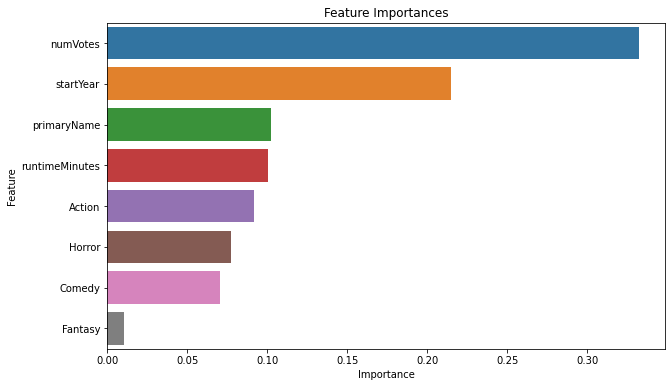

In [20]:
importances = RandomForestRegressor(**rf_cv.best_params_, random_state=123).fit(X_train, y_train).feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()


In [ ]:
rf_estimator=RandomForestRegressor(**rf_cv.best_params_, random_state=123).fit(X, y)

NameError: name 'new_G' is not defined

In [ ]:

ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=KFold(n_splits=5, shuffle=True, random_state=123))
ridge_cv.fit(X_train, y_train)
print("Best parameters for Ridge:", ridge_cv.best_params_)